In [1]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from loader import PathDataModule
from tqdm import tqdm

# --- 1. Configuration and Data Loading ---
config_path = 'full.json'
config_data = json.load(open(config_path, 'r'))
print(config_data)

{'dataset': 'ogbl-collab', 'storage_dir': '../data/', 'embedding_config': './full_embedding.json', 'train_ratio': 0.3, 'hidden_dim': 128, 'max_hops': 4, 'num_neg': 50, 'num_threads': 'vast', 'max_epochs': 2, 'batch_size': 'vast', 'dim_feedforward': 128, 'nhead': 4, 'num_layers': 4, 'dropout': 0.1, 'store': 'model', 'save_text_embeddings': True, 'shallow': True, 'pre_scan': ['train'], 'adjust_no_neg_paths_samples': True, 'max_adjust': 5.0, 'positive_deviation': True, 'embedding': 'all', 'test_time': 1, 'num_ckpt': 2, 'scale_loss': True, 'chi2': False, 'lr': 0.0001, 'wandb_project': 'thesis-graph'}


In [2]:
import torch

In [3]:
import os, requests, json, pprint

try:
    cid  = os.getenv("CONTAINER_ID")          # ← set by Vast.ai inside every container
    key  = os.getenv("CONTAINER_API_KEY")     # ← scoped token for this one instance
    assert cid and key, "Not running on a Vast.ai container!"

    resp = requests.get(
        f"https://console.vast.ai/api/v0/instances/{cid}/",
        headers={"Authorization": f"Bearer {key}",
                "accept": "application/json"},
        timeout=10,
    )

    info = resp.json()
    print("Effective vCPUs:", info['instances']["cpu_cores_effective"])
    # print(info['instances'].keys())
except Exception as e:
    print("Not running on Vast.ai container, or failed to fetch instance info.")
    print("Error:", e)

Not running on Vast.ai container, or failed to fetch instance info.
Error: Not running on a Vast.ai container!


In [4]:
import json
import os

embedding_cfg_path = config_data['embedding_config'] # path to config file
print("Embedding config path:", embedding_cfg_path)
# Read config from json file at embedding cfg path
with open(embedding_cfg_path, 'r') as f:
    embedding_cfg = json.load(f)
    
embedding_cfg

Embedding config path: ./full_embedding.json


{'batch_size': 4096,
 'lr': 0.001,
 'epochs': 10,
 'model_name': 'transe',
 'hidden_channels': 128,
 'p_norm': 2}

In [5]:


# --- 2. Load exported JSON results from model.py ---

# Construct the path to your export (update these variables as needed)
save_dir = config_data['storage_dir'] + embedding_cfg['model_name'] + \
    "/" + config_data['dataset'] + "/" + config_data['wandb_project']
    
print(f"Save directory: {save_dir}")


Save directory: ../data/transe/ogbl-collab/thesis-graph


In [6]:
wandb_name = "2"      
stage = "val"  # or "test"
epoch = "0"  # e.g. "9"
test_time = False  # set True if test_time

prefix = "test" if test_time else "train"
export_path = os.path.join(save_dir, wandb_name, f"{prefix}_{stage}_{epoch}_raw.json")
print(export_path)

../data/transe/ogbl-collab/thesis-graph/2/train_val_0_raw.json


In [7]:
# Load the JSON file
with open(export_path, "r") as f:
    export_items = json.load(f)

print(f"Loaded {len(export_items)}")

Loaded 160084


In [8]:
export_items[0]

{'score': 0.10750281810760498,
 'length': 1,
 'label': 1,
 'has_neg': True,
 'pos_dist': [15.462690353393555],
 'neg_dist': [[12.960073471069336],
  [12.960073471069336],
  [12.960073471069336],
  [12.960073471069336],
  [13.251718521118164],
  [15.462690353393555],
  [15.462690353393555],
  [15.462690353393555],
  [13.712559700012207],
  [13.712559700012207],
  [13.712559700012207],
  [12.98974895477295],
  [12.98974895477295],
  [13.873517036437988],
  [13.166553497314453],
  [15.610689163208008],
  [12.945801734924316],
  [15.426545143127441],
  [14.956171035766602],
  [15.73241138458252]],
 'adjusted_score': 5.1075029373168945,
 'mean_z': 1.2399181127548218,
 'loss': 1.0412794351577759}

In [9]:
# recompute adjusted score
max_hops = config_data['max_hops']
max_adjust = config_data['max_adjust']
print(f"Max hops: {max_hops}, Max adjust: {max_adjust}")

Max hops: 4, Max adjust: 5.0


In [10]:
# length zero adjusted to max_hops + 2
for item in tqdm(export_items):
    if item['length'] == 0:
        item['length'] = max_hops + 2

min_length = min(item['length'] for item in export_items)
print(f"Minimum length: {min_length}")

100%|██████████| 160084/160084 [00:00<00:00, 3708553.13it/s]

Minimum length: 1


In [11]:
# adjusted score
for item in tqdm(export_items):
    # ratio = 1 - (item['length'] - min_length) / (max_hops + 1 - min_length)
    # item['adjusted_score'] = item['score'] + (ratio * max_adjust)
    item['adjusted_score'] = item['score']

  0%|          | 0/160084 [00:00<?, ?it/s]

100%|██████████| 160084/160084 [00:00<00:00, 2261139.87it/s]


In [12]:
# Re-compute the percentile pos for each items in given export_items
for item in tqdm(export_items):
    if item['pos_dist'] is not None:
        pos = torch.tensor(item['pos_dist'])
        if item['neg_dist'] is None:
            item['percentile_pos'] = 1.0
            continue
        
        neg = torch.tensor(item['neg_dist'])
        
        if config_data["positive_deviation"]:
            neg = torch.cat([neg, pos.unsqueeze(0)], dim=0)
        
        mean, std = neg.mean(0), neg.std(0, correction=0)
        z = torch.where(std > 1e-4, (pos - mean) / std,
                        torch.zeros(pos.shape, dtype=pos.dtype, device=pos.device))
        mean_z = z.mean()
    
        item['loss'] = mean_z.item() if config_data['scale_loss'] else torch.asinh(mean_z).item()
        item['percentile_pos'] = 1.0 - torch.special.ndtr(mean_z).item()
    else:
        item['percentile_pos'] = 0.0

100%|██████████| 160084/160084 [00:03<00:00, 45620.43it/s] 


In [13]:
export_items[3]

{'score': 0.0,
 'length': 6,
 'label': 1,
 'has_neg': False,
 'pos_dist': None,
 'neg_dist': None,
 'adjusted_score': 0.0,
 'mean_z': None,
 'loss': None,
 'percentile_pos': 0.0}

In [14]:
# Get list of label 0 but non-zero length
neg_items = [item for item in export_items if item['label'] == 0 and item['has_neg']]
print(f"Filtered non-zero items: {len(neg_items)}")

Filtered non-zero items: 7083


In [15]:
neg_items[200]

{'score': 0.975851833820343,
 'length': 4,
 'label': 0,
 'has_neg': True,
 'pos_dist': [14.205718994140625,
  14.845471382141113,
  13.80765151977539,
  7.599095821380615],
 'neg_dist': [[14.205718994140625,
   14.925834655761719,
   15.032785415649414,
   14.57801342010498],
  [14.205718994140625,
   14.925834655761719,
   15.032785415649414,
   14.782130241394043],
  [15.836421966552734,
   13.316373825073242,
   14.806684494018555,
   14.716327667236328],
  [15.836421966552734,
   13.316373825073242,
   14.806684494018555,
   14.716327667236328],
  [15.836421966552734,
   13.316373825073242,
   14.806684494018555,
   14.716327667236328],
  [15.836421966552734,
   13.316373825073242,
   14.806684494018555,
   14.671391487121582],
  [15.836421966552734,
   13.316373825073242,
   14.806684494018555,
   14.671391487121582],
  [15.836421966552734,
   13.316373825073242,
   14.806684494018555,
   14.671391487121582],
  [14.205718994140625,
   14.845471382141113,
   14.79312515258789,
   1

In [16]:
pos_items = [item for item in export_items if item['label'] == 1 and item['has_neg']]
print(f"Filtered positive items: {len(pos_items)}")

Filtered positive items: 47553


In [17]:
pos_items[0]

{'score': 0.10750281810760498,
 'length': 1,
 'label': 1,
 'has_neg': True,
 'pos_dist': [15.462690353393555],
 'neg_dist': [[12.960073471069336],
  [12.960073471069336],
  [12.960073471069336],
  [12.960073471069336],
  [13.251718521118164],
  [15.462690353393555],
  [15.462690353393555],
  [15.462690353393555],
  [13.712559700012207],
  [13.712559700012207],
  [13.712559700012207],
  [12.98974895477295],
  [12.98974895477295],
  [13.873517036437988],
  [13.166553497314453],
  [15.610689163208008],
  [12.945801734924316],
  [15.426545143127441],
  [14.956171035766602],
  [15.73241138458252]],
 'adjusted_score': 0.10750281810760498,
 'mean_z': 1.2399181127548218,
 'loss': 1.2399171590805054,
 'percentile_pos': 0.10750305652618408}

In [18]:
K = 50
# Select top K items in negative highest adjsuted scores
top_neg = sorted(
    neg_items, key=lambda x: x['percentile_pos'], reverse=True)[:K]
print(f"Top {K} negative items: {len(top_neg)}")

Top 50 negative items: 50


In [19]:
top_neg[-1]

{'score': 0.9999960660934448,
 'length': 4,
 'label': 0,
 'has_neg': True,
 'pos_dist': [12.284375190734863,
  9.813383102416992,
  1.6950284242630005,
  7.609344482421875],
 'neg_dist': [[16.01152229309082,
   12.675353050231934,
   14.790236473083496,
   14.491157531738281],
  [16.01152229309082,
   12.675353050231934,
   14.790236473083496,
   14.491157531738281],
  [16.01152229309082,
   12.675353050231934,
   14.790236473083496,
   14.397222518920898],
  [16.01152229309082,
   12.675353050231934,
   14.790236473083496,
   14.397222518920898],
  [16.01152229309082,
   12.675353050231934,
   14.790236473083496,
   14.397222518920898],
  [16.01152229309082,
   12.675353050231934,
   14.790236473083496,
   14.397222518920898],
  [16.01152229309082,
   12.675353050231934,
   14.790236473083496,
   14.37536334991455],
  [16.01152229309082,
   12.675353050231934,
   14.790236473083496,
   14.37536334991455],
  [16.01152229309082,
   12.675353050231934,
   14.790236473083496,
   14.377911

In [20]:
top_neg_score = top_neg[-1]['percentile_pos']
print(f"Top negative score: {top_neg_score}")

Top negative score: 0.9999960064888


In [21]:
torch.tensor(top_neg[-1]['neg_dist'])

tensor([[16.0115, 12.6754, 14.7902, 14.4912],
        [16.0115, 12.6754, 14.7902, 14.4912],
        [16.0115, 12.6754, 14.7902, 14.3972],
        [16.0115, 12.6754, 14.7902, 14.3972],
        [16.0115, 12.6754, 14.7902, 14.3972],
        [16.0115, 12.6754, 14.7902, 14.3972],
        [16.0115, 12.6754, 14.7902, 14.3754],
        [16.0115, 12.6754, 14.7902, 14.3754],
        [16.0115, 12.6754, 14.7902, 14.3779],
        [16.0115, 12.6754, 14.7902, 14.3779],
        [16.0115, 12.6754, 14.7902, 14.3429],
        [16.0115, 12.6754, 14.7902, 14.3429],
        [16.0115, 12.6563, 14.4707, 14.3469],
        [16.0115, 12.6563, 14.4707, 14.3469],
        [16.0115, 12.6754, 14.7902, 14.2735],
        [16.0115, 12.6754, 14.7902, 14.2735],
        [16.0115, 12.4663, 14.6897, 14.2247],
        [16.0115, 12.6754, 14.7902, 14.5855],
        [16.0115, 12.6754, 14.7902, 14.5855],
        [16.0115, 12.6754, 14.7902, 14.5855]])

In [22]:
# Sort the positive items by adjusted score
top_pos = sorted(pos_items, key=lambda x: x['percentile_pos'], reverse=True)
print(f"Top positive items: {len(top_pos)}")

Top positive items: 47553


In [23]:
top_pos[-1]

{'score': 3.874301910400391e-06,
 'length': 4,
 'label': 1,
 'has_neg': True,
 'pos_dist': [16.070083618164062,
  13.146574020385742,
  14.963539123535156,
  14.693155288696289],
 'neg_dist': [[13.69365119934082,
   12.98227310180664,
   7.553370475769043,
   12.711535453796387],
  [13.69365119934082,
   12.98227310180664,
   7.553370475769043,
   12.711535453796387],
  [13.69365119934082,
   12.98227310180664,
   7.553370475769043,
   12.711535453796387],
  [13.69365119934082,
   12.98227310180664,
   7.553370475769043,
   12.711535453796387],
  [13.69365119934082,
   12.98227310180664,
   7.553370475769043,
   12.711535453796387],
  [13.69365119934082,
   12.98227310180664,
   7.553370475769043,
   12.711535453796387],
  [13.69365119934082,
   12.98227310180664,
   7.553370475769043,
   12.711535453796387],
  [13.69365119934082,
   12.98227310180664,
   7.553370475769043,
   12.711535453796387],
  [13.69365119934082,
   12.98227310180664,
   7.553370475769043,
   12.711535453796387],

In [24]:
# How many pos items higher adjusted scores than last item in top_neg
higher_pos = [
    item for item in top_pos if item['percentile_pos'] > top_neg_score]
len(higher_pos)

145

In [25]:
len(higher_pos) / len(pos_items)

0.003049229281012765

In [26]:
top_neg[2]

{'score': 0.9999961256980896,
 'length': 4,
 'label': 0,
 'has_neg': True,
 'pos_dist': [13.994376182556152,
  13.588933944702148,
  13.632014274597168,
  3.240152359008789],
 'neg_dist': [[14.456518173217773,
   13.721488952636719,
   14.620986938476562,
   14.500174522399902],
  [14.456518173217773,
   13.721488952636719,
   14.620986938476562,
   14.500174522399902],
  [14.456518173217773,
   13.721488952636719,
   14.620986938476562,
   14.500174522399902],
  [14.456518173217773,
   13.721488952636719,
   14.620986938476562,
   14.500174522399902],
  [14.456518173217773,
   13.721488952636719,
   14.620986938476562,
   14.500174522399902],
  [14.456518173217773,
   13.721488952636719,
   14.620986938476562,
   14.500174522399902],
  [14.456518173217773,
   13.721488952636719,
   14.620986938476562,
   14.500174522399902],
  [14.456518173217773,
   13.721488952636719,
   14.620986938476562,
   14.500174522399902],
  [14.456518173217773,
   13.721488952636719,
   14.620986938476562,


In [27]:
higher_pos[-1]

{'score': 0.9999960660934448,
 'length': 3,
 'label': 1,
 'has_neg': True,
 'pos_dist': [10.830842018127441, 8.944114685058594, 1.5853381156921387],
 'neg_dist': [[15.29787826538086, 13.035932540893555, 6.360732555389404],
  [15.29787826538086, 13.035932540893555, 6.360732555389404],
  [15.29787826538086, 13.035932540893555, 6.360732555389404],
  [15.29787826538086, 13.035932540893555, 6.360732555389404],
  [15.29787826538086, 13.035932540893555, 6.360732555389404],
  [15.29787826538086, 13.035932540893555, 6.360732555389404],
  [15.29787826538086, 13.035932540893555, 6.360732555389404],
  [15.29787826538086, 13.035932540893555, 6.360732555389404],
  [15.29787826538086, 13.035932540893555, 6.360732555389404],
  [15.29787826538086, 13.035932540893555, 6.360732555389404],
  [15.29787826538086, 13.035932540893555, 6.360732555389404],
  [15.29787826538086, 13.035932540893555, 6.360732555389404],
  [15.29787826538086, 13.035932540893555, 6.360732555389404],
  [15.29787826538086, 13.03593254

In [28]:
# example = top_pos[40000]
example = top_neg[2]
example

{'score': 0.9999961256980896,
 'length': 4,
 'label': 0,
 'has_neg': True,
 'pos_dist': [13.994376182556152,
  13.588933944702148,
  13.632014274597168,
  3.240152359008789],
 'neg_dist': [[14.456518173217773,
   13.721488952636719,
   14.620986938476562,
   14.500174522399902],
  [14.456518173217773,
   13.721488952636719,
   14.620986938476562,
   14.500174522399902],
  [14.456518173217773,
   13.721488952636719,
   14.620986938476562,
   14.500174522399902],
  [14.456518173217773,
   13.721488952636719,
   14.620986938476562,
   14.500174522399902],
  [14.456518173217773,
   13.721488952636719,
   14.620986938476562,
   14.500174522399902],
  [14.456518173217773,
   13.721488952636719,
   14.620986938476562,
   14.500174522399902],
  [14.456518173217773,
   13.721488952636719,
   14.620986938476562,
   14.500174522399902],
  [14.456518173217773,
   13.721488952636719,
   14.620986938476562,
   14.500174522399902],
  [14.456518173217773,
   13.721488952636719,
   14.620986938476562,


In [29]:
pos = torch.tensor(example['pos_dist']) # (length, )
neg = torch.tensor(example['neg_dist']) # (num_neg, length)

In [30]:
if config_data["positive_deviation"]:
    # Add pos (length, ) to neg pool (num_neg, length)
    neg = torch.cat([neg, pos.unsqueeze(0)], dim=0)

In [31]:
pos.shape, neg.shape

(torch.Size([4]), torch.Size([21, 4]))

In [32]:
pos

tensor([13.9944, 13.5889, 13.6320,  3.2402])

In [33]:
neg

tensor([[14.4565, 13.7215, 14.6210, 14.5002],
        [14.4565, 13.7215, 14.6210, 14.5002],
        [14.4565, 13.7215, 14.6210, 14.5002],
        [14.4565, 13.7215, 14.6210, 14.5002],
        [14.4565, 13.7215, 14.6210, 14.5002],
        [14.4565, 13.7215, 14.6210, 14.5002],
        [14.4565, 13.7215, 14.6210, 14.5002],
        [14.4565, 13.7215, 14.6210, 14.5002],
        [14.4565, 13.7215, 14.6210, 14.5002],
        [14.4565, 13.7215, 14.6210, 14.5002],
        [14.4565, 13.7215, 14.6210, 14.5002],
        [14.4565, 13.7215, 14.6210, 14.5002],
        [14.4565, 13.7215, 14.6210, 14.4915],
        [14.4565, 13.7215, 14.6210, 14.4915],
        [14.4565, 13.7215, 14.6210, 14.4915],
        [14.4565, 13.7215, 14.6210, 14.4915],
        [14.4565, 13.7215, 14.6210, 14.4915],
        [14.4565, 13.7215, 14.6210, 14.4915],
        [14.4565, 13.7215, 14.6210, 14.4915],
        [14.4565, 13.7215, 14.6210, 14.4915],
        [13.9944, 13.5889, 13.6320,  3.2402]])

In [34]:
mean, std = neg.mean(0), neg.std(0, correction=0)
print(mean, std)

tensor([14.4345, 13.7152, 14.5739, 13.9607]) tensor([0.0984, 0.0282, 0.2106, 2.3972])


In [35]:
z = torch.where(std > 1e-4, (pos - mean) / std, torch.zeros(pos.shape, dtype=pos.dtype, device=pos.device))
mean_z = z.mean()
print(z, mean_z)

tensor([-4.4721, -4.4722, -4.4721, -4.4721]) tensor(-4.4721)


In [36]:
# arcsinh(mean z)
arcsinh_mean_z = torch.asinh(mean_z)
print(f"Arcsinh mean z: {arcsinh_mean_z}")

Arcsinh mean z: -2.2032852172851562


In [37]:
percentile_pos = 1.0 - torch.special.ndtr(mean_z).item()

In [38]:
print(f"Percentile of positive item: {percentile_pos:.4f}")

Percentile of positive item: 1.0000


In [39]:
pos_losses = torch.tensor([item['loss'] for item in pos_items])
neg_losses = torch.tensor([item['loss'] for item in neg_items])
print(pos_losses.shape, neg_losses.shape)

torch.Size([47553]) torch.Size([7083])


In [40]:
print(pos_losses.mean(), pos_losses.std())
print(neg_losses.mean(), neg_losses.std())

tensor(-1.1399) tensor(1.4654)
tensor(-1.5057) tensor(1.6852)


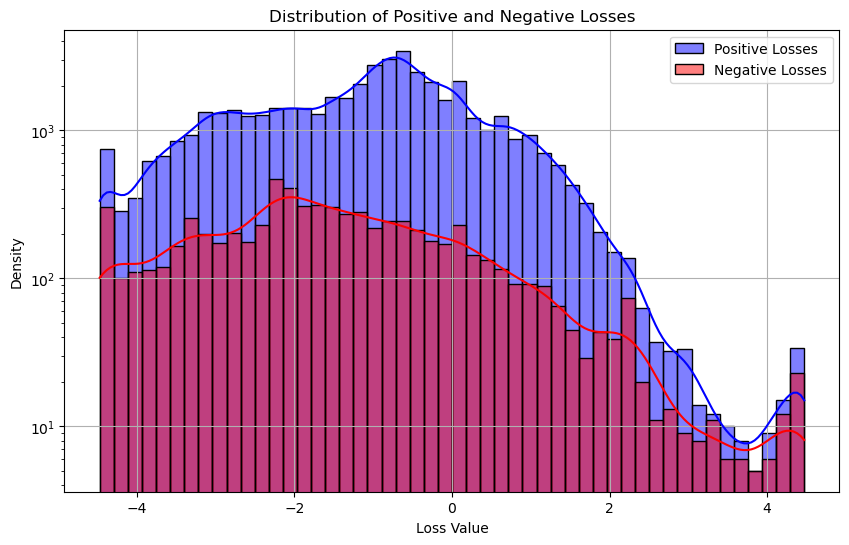

In [43]:
# Plot distribution of these two pos neg losses
plt.figure(figsize=(10, 6))
sns.histplot(pos_losses, bins=50, color='blue', label='Positive Losses', kde=True, stat='count')
sns.histplot(neg_losses, bins=50, color='red', label='Negative Losses', kde=True, stat='count')
plt.title('Distribution of Positive and Negative Losses')
plt.xlabel('Loss Value')
plt.ylabel('Density')
# log scale yaxis
plt.yscale('log')
plt.legend()
plt.grid()
plt.show()

In [44]:
export_items[0]

{'score': 0.10750281810760498,
 'length': 1,
 'label': 1,
 'has_neg': True,
 'pos_dist': [15.462690353393555],
 'neg_dist': [[12.960073471069336],
  [12.960073471069336],
  [12.960073471069336],
  [12.960073471069336],
  [13.251718521118164],
  [15.462690353393555],
  [15.462690353393555],
  [15.462690353393555],
  [13.712559700012207],
  [13.712559700012207],
  [13.712559700012207],
  [12.98974895477295],
  [12.98974895477295],
  [13.873517036437988],
  [13.166553497314453],
  [15.610689163208008],
  [12.945801734924316],
  [15.426545143127441],
  [14.956171035766602],
  [15.73241138458252]],
 'adjusted_score': 0.10750281810760498,
 'mean_z': 1.2399181127548218,
 'loss': 1.2399171590805054,
 'percentile_pos': 0.10750305652618408}